In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import math

from typeguard import typechecked
from typing import Tuple

import numpy as np

import torch
from torch import nn

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Device Agnostic Programming
# device = "mps" if torch.backends.mps.is_available() else "cpu"

In [2]:
stock = "IBM"

# Automatic download of stock price
# own API key for Alpha Vantage: 306SNP4A1M8AB5K4
# url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=" + stock + "&outputsize=full&apikey=306SNP4A1M8AB5K4&datatype=csv"
# data = pd.read_csv(url)

full_data = pd.read_csv("./data/daily_IBM.csv")

# Take only the closing prices
data = full_data[['close']].astype('float32')


# Reverse the data to get top -> down (old -> new) ordering
data = data.iloc[::-1].reset_index(drop=True)
no_datapoints = data.shape[0]

In [3]:
def show_chart(data: pd.DataFrame, trainPredictPlot: np.ndarray, testPredictPlot: np.ndarray):
    """
    args:
        data: full pandas data frame including the complete csv file downloaded from Alpha Vantage 
    
    returns:
        -
    """
    plt.plot(data['timestamp'], data['close'], linestyle = 'solid')
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.title("Closing Prices for the last " + str(no_datapoints) + " days for " + stock)
    plt.xticks([1, math.ceil(no_datapoints/2), no_datapoints-1])
    plt.show()

In [8]:
@typechecked
def train_test_validation_split(data: pd.DataFrame) -> Tuple[
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame]:
    """
    args: 
        data: pandas data frame including the closing prices

    returns:
        train_set: 70% of the complete data set for training purpose
        test_set: 20% of the complete data set for test purpose
        validation_set: 10% of the compete data set for validation purpose
    """
    # Plit into 70% train set, 20% test set and 10% validation set
    train_set_end_index = math.ceil(no_datapoints*0.7)
    test_set_end_index = math.ceil(no_datapoints)
    
    train_set = data.iloc[:train_set_end_index, :]
    test_set = data.iloc[train_set_end_index:test_set_end_index, :]

    # Neglect validation set at current set-up
    # validation_set = data.iloc[test_set_end_index:, :]
    validation_set = pd.DataFrame(np.zeros((1,1)))

    return train_set, test_set, validation_set

In [9]:
@typechecked
def get_scaled_closing_prices(data: pd.DataFrame) -> Tuple[
    pd.DataFrame,
    float]:
    """
    args: 
        data: pandas data frame including the complete csv file downloaded from Alpha Vantage 
        scaler: MinMaxScaler
    returns:
        scaled_close: closing prices scaled 0-1 range 
        maximum_value: highest closing price by which we divide all the other closing prices to scale down to 0 - 1
    """
    maximum_value = data['close'].max()
    scaled_closing_prices = data / maximum_value
    return scaled_closing_prices, maximum_value

In [10]:
# Prepare the input and output sequences as np.arrays based on the data from the csv file
# The input sequence contains all elements in a window before the element of interest with window size sequence_length
@typechecked
def create_sequences(data: pd.DataFrame, window_size: int) -> Tuple[
    np.ndarray,
    np.ndarray]:
    """
    args: 
        data: pandas data frame including the closing prices
        window_size: window size of input sequence which is of relevance for the prediction of the next output
    returns:
        X: input sequence, i.e. the last sequence_length data points which are relevant for the prediction of the next one
        y: output 
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        # Extract the input sequence and ensure it is a NumPy array
        X.append(data.iloc[i:(i+window_size)].to_numpy())
        # Extract the output value and ensure it is a scalar value, not a Series
        y.append(data.iloc[i+window_size].to_numpy())
    
    # Convert lists to NumPy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [11]:
# Get the scaled closing prices scaled to an interval of 0 - 1 for more stable training
# Scaling gives the factor to scale the output up again to the real value
scaled_closing_prices, scaling = get_scaled_closing_prices(data)

# Get the training, test and validation split
# Validation set is at current set-up not existent
train_set, test_set, validation_set = train_test_validation_split(scaled_closing_prices)

In [18]:
# Number of past days we take into consideration to predict the next closing price
window_size = 5

# Get input - output pairs from the given closing price sequence
train_X, train_Y = create_sequences(train_set, window_size)
test_X, test_Y = create_sequences(test_set, window_size)
# validation_X, validation_Y = create_sequences(validation_set, window_size)

# Prepare the data sets for the correct shape to be used in the LSTM
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
# validation_X = np.reshape(validation_X, (validation_X.shape[0], 1, validation_X.shape[1]))

In [23]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, window_size)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# Set verbose to 1 or 2 to see the progress during learning
model.fit(train_X, train_Y, epochs=1000, batch_size=1, verbose=0)

In [20]:
# get predictions from the model
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

# scale predictions up to the original price level
trainPredict = trainPredict * scaling
testPredict = testPredict * scaling

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(train_Y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(test_Y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train Score: 174.17 RMSE
Test Score: 186.51 RMSE


100


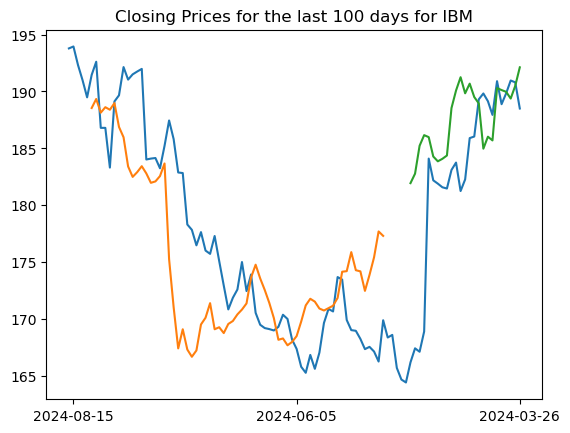

In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict

print(len(trainPredict)+len(testPredict) + (window_size*2))


# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(trainPredict)+len(testPredict) + (window_size*2), :] = testPredict
# plot baseline and predictions
show_chart(full_data, trainPredictPlot, testPredictPlot)